# Telemetry EDA Case Study — Assignment

**Context:** You are analyzing telemetry from 50 IoT edge devices over 7 days (30‑min intervals).

**Goal:** Clean the data, explore patterns, quantify relationships, and present actionable reliability/performance insights.

**Dataset file:** `iot_telemetry.csv` (place in the same folder as this notebook).

**Deliverables:**
- A short report or slide deck summarizing findings and recommendations.
- This notebook with completed analysis and visualizations.
- (Optional) A simple predictive baseline for error/high-latency risk.

> Tip: Keep notes of assumptions and decisions (e.g., imputation choices) — they matter for reproducibility and credibility.

## Data Dictionary
- `timestamp` (ISO) — 30‑minute intervals for 7 days
- `device_id` — device identifier (50 unique)
- `zone` — {North, South, East, West, Central} (network quality varies)
- `firmware` — {1.0, 1.1, 1.2, 2.0} (older has higher error risk)
- `signal_strength` (0–100) — lower signal → higher latency
- `battery_level` (0–100) — gradual decay, faster under high CPU/errors
- `cpu_usage`, `mem_usage` (0–100) — diurnal cycle; memory tracks CPU
- `temp_c` (°C) — ambient + CPU heat (afternoons warmer)
- `latency_ms` — inversely related to signal; higher under load/errors
- `event` — {normal, warning, error}
- `error_code` — codes on errors (e.g., E101, E202)

## Grading Rubric (85 pts + 15 bonus)
A) Data hygiene & justification — 10

B) Distributions & summaries — 15

C) Relationships (corr + plots + interpretation) — 20

D) Time patterns (hour/day) — 15

E) Reliability analysis & recommendations — 25

Bonus: Feature engineering + baseline model — 15

In [1]:
# Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8')
pd.set_option('display.max_columns', None)
np.random.seed(42)
%matplotlib inline


## Part A — Data Hygiene (10 pts)

**A1.** Load the dataset and report shape, dtypes, and a 5‑row preview.

**A2.** Quantify missing values per column. Propose and apply appropriate handling (e.g., numeric median imputation). Justify choices.

**A3.** Check for duplicates and remove if present. Identify extreme outliers (e.g., unusually high `latency_ms`). Briefly state your detection criteria.

**A4.** Summarize data quality decisions in 3–4 bullet points.

In [2]:
# Part A — Data Hygiene
# TODO: Update path if needed
df = pd.read_csv('iot_telemetry_7days_v3.csv', parse_dates=['timestamp'])
print('Shape:', df.shape)
print('Dtypes:', df.dtypes)
display(df.head()) # 5‑row preview.

# Missing values
missing = df.isna().sum().sort_values(ascending=False)
print('Missing values per column:', missing)



Shape: (16800, 12)
Dtypes: timestamp          datetime64[ns, UTC+05:30]
device_id                             object
zone                                  object
firmware                             float64
signal_strength                      float64
battery_level                        float64
cpu_usage                            float64
mem_usage                            float64
temp_c                               float64
latency_ms                           float64
event                                 object
error_code                            object
dtype: object


,timestamp,device_id,zone,firmware,signal_strength,battery_level,cpu_usage,mem_usage,temp_c,latency_ms,event,error_code
0,2025-12-11 09:30:00+05:30,DEV-0001,West,1.0,65.47,99.92,41.76,31.20,29.75,102.78,warning,NaN
1,2025-12-11 10:00:00+05:30,DEV-0001,West,1.0,52.05,99.83,57.53,51.89,31.15,114.31,warning,NaN
2,2025-12-11 10:30:00+05:30,DEV-0001,West,1.0,55.17,99.75,48.22,36.50,32.34,113.45,warning,NaN
3,2025-12-11 11:00:00+05:30,DEV-0001,West,1.0,54.06,99.66,57.51,58.57,33.07,119.09,warning,NaN
4,2025-12-11 11:30:00+05:30,DEV-0001,West,1.0,38.82,99.57,45.29,42.39,32.73,108.87,warning,NaN


Missing values per column: error_code         16721
timestamp              0
zone                   0
device_id              0
firmware               0
signal_strength        0
cpu_usage              0
battery_level          0
mem_usage              0
temp_c                 0
latency_ms             0
event                  0
dtype: int64


In [3]:
# Example imputations (justify in markdown):
num_cols = df.select_dtypes(include=np.number).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# For categorical, consider leaving as NaN or imputing mode
cat_cols = df.select_dtypes(include='object').columns
# df[cat_cols] = df[cat_cols].fillna(df[cat_cols].mode().iloc[0])  # Optional

# Duplicates
dups = df.duplicated().sum()
print('Duplicates:', dups)
df = df.drop_duplicates()

# Outlier check (example): Latency beyond 99th percentile
p99 = df['latency_ms'].quantile(0.99)
print('99th percentile latency:', p99)
outliers = df[df['latency_ms'] > p99]
print('Potential latency outliers:', len(outliers))

Duplicates: 0
99th percentile latency: 144.27029999999996
Potential latency outliers: 168


## Part B — Descriptive EDA (15 pts)

**B1.** Plot distributions (histograms + KDE) for: `cpu_usage`, `mem_usage`, `temp_c`, `signal_strength`, `latency_ms`, `battery_level`.

**B2.** Report mean, median, and std for the above metrics. Comment on skew/outliers.

**B3.** Identify devices or zones with consistently **low signal** or **high latency**. Provide 2–3 observations.

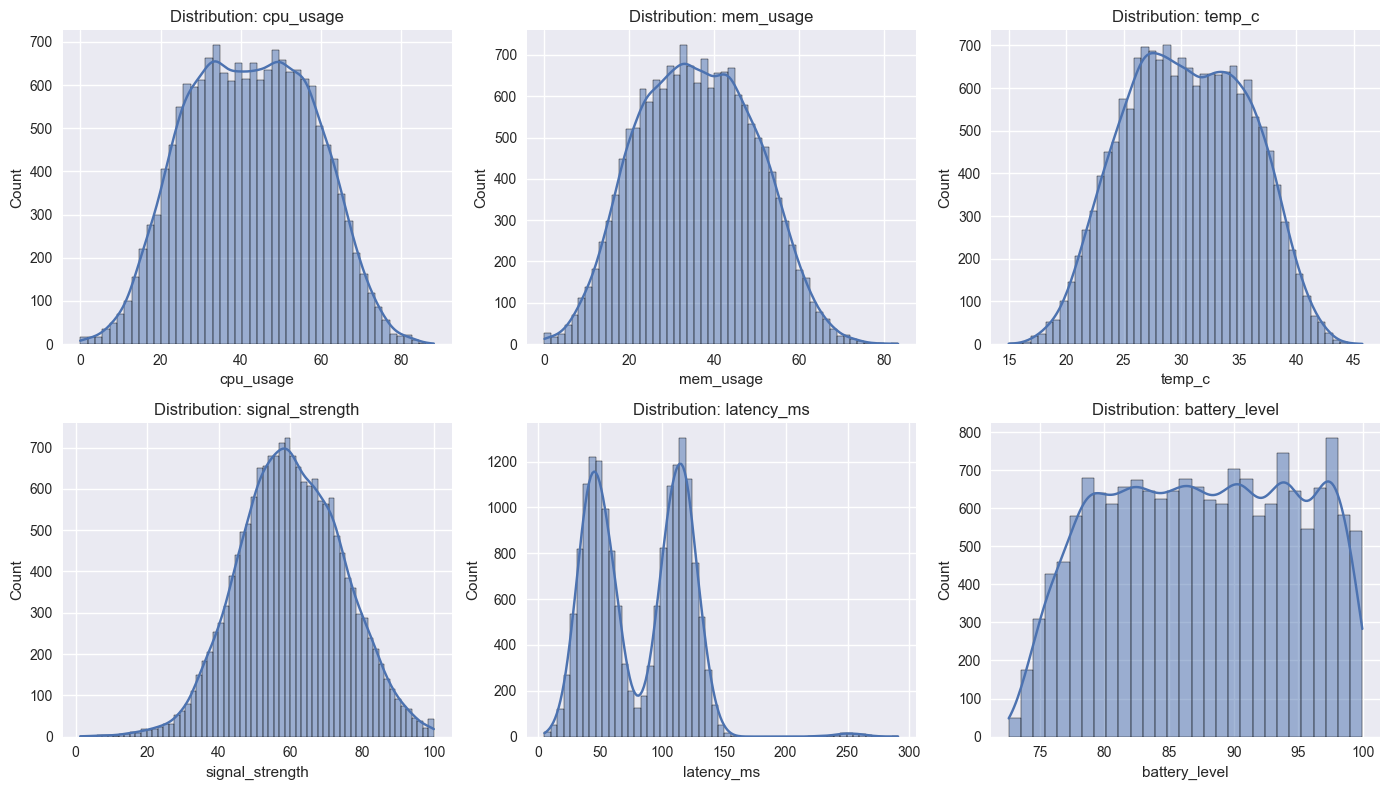

In [4]:
# Part B — Descriptive EDA
metrics = ['cpu_usage','mem_usage','temp_c','signal_strength','latency_ms','battery_level']
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
for ax, col in zip(axes.ravel(), metrics):
    sns.histplot(df[col], kde=True, ax=ax)
    ax.set_title(f'Distribution: {col}')
plt.tight_layout(); 
plt.show()


In [ ]:
# Summaries
summary = df[metrics].agg(['mean','median','std']).T
display(summary)


In [ ]:
# By device/zone (adjust thresholds as needed)
by_device = df.groupby('device_id')[['signal_strength','latency_ms']].mean().sort_values('signal_strength')
display(by_device.head())
by_zone = df.groupby('zone')[['signal_strength','latency_ms']].mean().sort_values('signal_strength')
display(by_zone)

## Part C — Relationships & Drivers (20 pts)

**C1.** Compute a **numeric-only correlation** matrix and visualize a heatmap.

**C2.** Based on correlation and plots, answer:
- Which features most strongly **increase** `latency_ms`?
- Which features are negatively correlated with `latency_ms`?

**C3.** Create scatter/regression plots for: `signal_strength` vs `latency_ms`, `cpu_usage` vs `latency_ms`, `temp_c` vs `latency_ms`.

**C4.** Interpret direction, strength, nonlinearity, and the role of outliers in 4–6 bullet points.

In [ ]:
# Part C — Correlations & Key Relationships
corr = df.select_dtypes(include=np.number).corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap'); plt.show()

# Helper: top correlations with latency
lat_corr = corr['latency_ms'].drop('latency_ms').sort_values(ascending=False)
display(lat_corr.head(10))

# Relationship plots
sns.regplot(data=df, x='signal_strength', y='latency_ms', scatter_kws={'alpha':0.3})
plt.title('Signal vs Latency'); plt.show()

sns.regplot(data=df, x='cpu_usage', y='latency_ms', scatter_kws={'alpha':0.3})
plt.title('CPU vs Latency'); plt.show()

sns.regplot(data=df, x='temp_c', y='latency_ms', scatter_kws={'alpha':0.3})
plt.title('Temperature vs Latency'); plt.show()


## Part D — Time Patterns (15 pts)

**D1.** Plot hour‑of‑day trends for `cpu_usage`, `temp_c`, and `latency_ms` (mean across all devices).

**D2.** Compare weekday vs weekend behavior (e.g., average `cpu_usage`, `latency_ms`).

**D3.** Identify peak hours for performance risk (high latency / warnings / errors) and explain drivers.

In [ ]:
# Part D — Time Patterns
df['hour'] = df['timestamp'].dt.hour
hourly = df.groupby('hour')[['cpu_usage','temp_c','latency_ms']].mean()
hourly.plot(figsize=(10,5), title='Hour-of-day trends'); plt.show()

df['weekday'] = df['timestamp'].dt.weekday
df['is_weekend'] = df['weekday'] >= 5
ww = df.groupby('is_weekend')[['cpu_usage','latency_ms']].mean()
print('
Weekday vs Weekend:
', ww)

# Event counts by hour (risk windows)
evt_by_hour = df.groupby(['hour','event']).size().unstack(fill_value=0)
display(evt_by_hour)
evt_by_hour.plot(kind='line', figsize=(10,5), title='Events by Hour'); plt.show()


## Part E — Reliability & Risk (25 pts)

**E1.** Compute per‑device **event rates** (normal/warning/error). Which devices are the riskiest?

**E2.** Calculate **zone‑level error rates**. Which zone needs network upgrades? Quantify the gap.

**E3.** Evaluate **firmware** impact on errors. Should any version be deprecated? Support with evidence.

**E4.** Recommend **two engineering actions** (e.g., firmware rollout, cooling, antenna changes) and estimate expected effect. Provide rationale.

In [ ]:
# Part E — Reliability & Risk
event_rates = df.groupby('device_id')['event'].value_counts(normalize=True).unstack(fill_value=0)
display(event_rates.sort_values(by='error', ascending=False).head(10))

zone_error_counts = df[df['event']=='error'].groupby('zone').size().sort_values(ascending=False)
display(zone_error_counts)

firmware_error_counts = df[df['event']=='error'].groupby('firmware').size().sort_values(ascending=False)
display(firmware_error_counts)


## Bonus — Feature Engineering & Baseline Model (15 pts)

**BNS1.** Engineer 2–3 features (e.g., 3‑hour rolling `avg_signal`, `cpu_mem_ratio`, `temp_excess = max(0, temp_c−40)`).

**BNS2.** Build a simple model to predict `error` vs `non‑error` **or** `high latency` (e.g., >150 ms). Report metrics (accuracy/precision/recall or R²/MAE).

**BNS3.** Identify top features and explain alignment with your EDA findings.

In [ ]:
# Bonus — Example baseline (classification: error vs non-error)
# NOTE: If scikit-learn is unavailable, skip modeling or implement a simple heuristic.
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Target: error (1) vs non-error (0)
df['target_error'] = (df['event'] == 'error').astype(int)

# Feature engineering examples
df = df.sort_values(['device_id','timestamp'])
df['avg_signal_3h'] = df.groupby('device_id')['signal_strength'].transform(lambda s: s.rolling(6, min_periods=1).mean())
df['cpu_mem_ratio'] = df['cpu_usage'] / (df['mem_usage'] + 1e-6)
df['temp_excess'] = (df['temp_c'] - 40).clip(lower=0)

# One-hot encode categorical
model_df = pd.get_dummies(df.drop(columns=['timestamp','error_code','event']), drop_first=True)
X = model_df.drop(columns=['target_error'])
y = model_df['target_error']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
lr = LogisticRegression(max_iter=500)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print(classification_report(y_test, y_pred))
print('Confusion matrix:
', confusion_matrix(y_test, y_pred))

# Top coefficients (feature importance proxy)
coef = pd.Series(lr.coef_[0], index=X.columns).sort_values(key=abs, ascending=False)
display(coef.head(10))


---
### Appendix (optional hints)
- Expect **negative correlation** between `signal_strength` and `latency_ms`.
- `cpu_usage` and `temp_c` have **diurnal patterns**; afternoons warmer.
- Errors are more likely when **signal is low** and **temperature is high**; older firmware has higher risk.
- When discussing recommendations, quantify expected impact (e.g., "a 10‑point signal improvement reduces latency by ~X ms").